# 최적화: 눈먼 등산객이 언덕 가장 낮은 곳을 찾아가는 방법

### 경사도 벡터와 헤시안 행렬

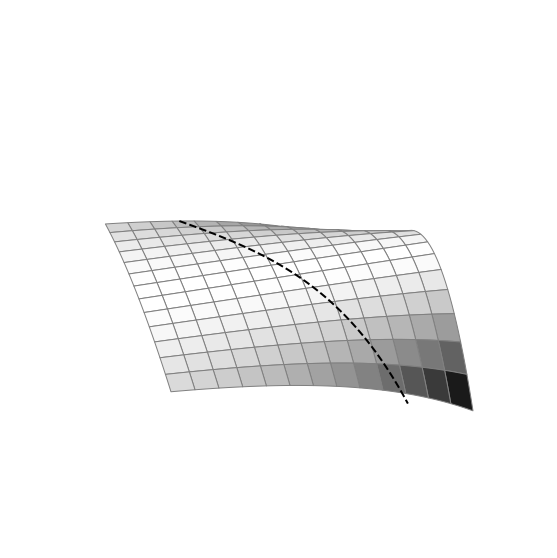

In [4]:
# 경사도 벡터
# 그림 8-11 등위면과 등위면 위를 지나는 곡선
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# f(x, y, z) = 0
x = y = np.arange(-1.0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
Z = -(1/3) * (X**2) * (np.exp(Y))

# 곡선 C에 대한 변수 t와 x(t), y(t), z(t)
t  = np.linspace(-0.5, 0.5, 100)
xt = np.array(2*t)
yt = np.array(t)
zt = -(1/3) * (xt**2) * (np.exp(yt))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 곡면 그리기
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, cmap=plt.cm.gray, edgecolor='gray', zorder=1)

# 곡면 위를 지나는 곡선 C = [xy, yt, zt]^T
ax.plot3D(xt, yt, zt, '--', lw=2, color='k', zorder=10)

ax.set_zlim(-1, 1)
ax.set_axis_off()
ax.view_init(35, -15)

plt.show()

In [7]:
# 헤시안 행렬
import sympy as sp

x1 = sp.Symbol('x1')
x2 = sp.Symbol('x2')

f = -sp.Rational(1, 3) * x1**2 * sp.E**x2

sp.derive_by_array(sp.derive_by_array(f, (x1, x2)), (x1, x2))

H = sp.derive_by_array(sp.derive_by_array(f, (x1, x2)), (x1, x2))
H.subs({x1:2, x2:0})

[[-2/3, -4/3], [-4/3, -4/3]]

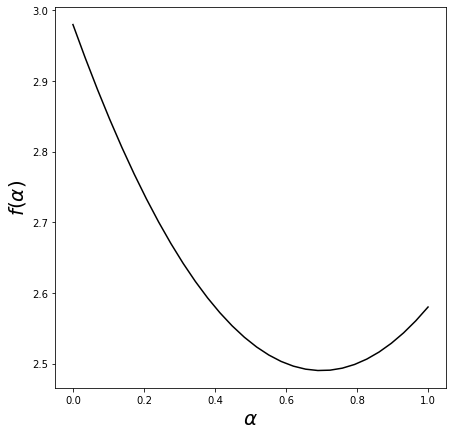

In [9]:
# 최속강하법
# 일변수 함수로 나타난 이변수 함수에 대한 탐색 경로
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

def f(X):
    return X[0]**2 + X[1]**2 + 2

x_0 = np.array([0.7, 0.7])
d = np.array([-1, 0])

def f_alpha(a):
    return f(x_0.reshape(2, 1) + a * d.reshape(2, 1))

alphas = np.linspace(0, 1, 30)
ax.plot(alphas, f_alpha(alphas), 'k')
ax.set_xlabel(r'$\alpha$', fontsize=20)
ax.set_ylabel(r'$f(\alpha)$', fontsize=20)

plt.show()

In [ ]:
# 표8-1 최속하강법 알고리즘

# 그림 8-19 왼쪽 함수와 도함수를 정의
def f1(X):
    return (X[0] + 2 * X[1] - 7)**2 + (2 * X[0] + X[1] - 5)**2

def df1(X):
    dx0 = 2 * (X[0] + 2 * X[1] - 7) + 4 * (2 * X[0] + X[1] - 5)
    dx1 = 4 * (X[0] + 2 * X[1] - 7) + 2 * (2 * X[0] + X[1] - 5)
    return np.array([dx0, dx1])

# 그림 8-19 오른쪽 함수와 도함수를 정의
def f2(X):
    return 50 * (X[1] - X[0]**2)**2 + (2 - X[0])**2

def df2(X):
    dx0 = -200 * X[0] * (X[1] - X[0]**2) - 2 * (2 - X[0])
    dx1 = 100 * (X[1] - X[0]**2)
    return np.array([dx0, dx1])

# 표 8-1 절차
from scipy.optimize import line_search

# 단계 1. 초기화: 시작점 x^(0)를 선정
x = np.array([0, 4.5])

# 수렴 상수는 설정에 속함
def SDM(f, df, x, eps=1.0e-7, callback=None):
    max_iter = 10000
    
    # 단계 1. 반복 횟수 k=0으로 설정
    for k in range(max_iter):
        # 단계 2. 경사도 벡터 계산: c^(k) = f(x^(k))를 계산
        c = df(x)
        
        # 단계 3. 수렴판정: c^(k)<E 이면 x^* = x^(k)로 두고 정지, 아니면 단계를 계속 진행
        if np.linalg.norm(c) < eps:
            print("Stop criterion break Iter.: {:5d}, x: {}".format(k, x))
            break
        
        # 단계 4. 강하 방향 설정: d^(k) = -c^(k)
        d = -c
        
        # 단계 5. 이동거리 계산: d^(k)를 따라 f(a) = f(x^(k) + a * d^(k))를 최소화하는 a_k를 계산
        alpha = line_search(f, df, x, d)[0]
        
        # 단계 6. 업데이트: x^(k+1) = x^(k) + a_k * d^(k)로 변수를 업데이트하고 k = k + 1로 두고 2로 가서 반복
        x = x + alpha * d
        
        if callback:
            callback(x)
        else:
            print("Stop max iter: {:5d} x:{}".format(k, x))

SDM(f1, df1, x)
SDM(f2, df2, np.array([-1, 2]))

In [14]:
# 켤레경사법
# 표 8-2 켤레경사법 알고리즘

# 단계 1. 초기화: 시작점 x^(0)를 선정
x = np.array([0, 4.5])

def CGM(f, df, x, eps=1.0e-7, callback=None):
    max_iter = 10000
    
    # 단계 1. 반복 횟수 k=0으로 설정
    for k in range(max_iter):
        # 단계 2. 경사도 벡터 계산: c^(k) = f(x^(k))를 계산
        c = df(x)
        
        # 단계 3. 수렴판정: c^(k)<E 이면 x^* = x^(k)로 두고 정지, 아니면 단계를 계속 진행
        if np.linalg.norm(c) < eps:
            print("Stop criterion break Iter: {:5d}, x: {}".format(k, x))
            break
        
        # 단계 4. 강하 방향 설정: d^(k) = -c^(k) 또는 d^(k) = -c^(k) + B_k * d^(k-1)
        if k == 0:
            d = -c
        else:
            beta = (np.linalg.norm(c) / np.linalg.norm(c_old))**2
            d = -c + beta * d
        
        # 단계 5. 이동거리 계산: d^(k)를 따라 f(a) = f(x^(k)) + a * d^(k)를 최소화하는 a_k를 계산
        alpha = line_search(f, df, x, d, c2=0.1)[0]
        
        # 단계 6. 업데이트: x^(k+1) = x^(k) + a_k * d^(k)로 변수를 업데이트하고 k = k + 1로 두고 2로 가서 반복
        x = x + alpha * d
        
        # 단계 7. 현재 정보 저장
        c_old = c.copy()
        
        if callback:
            callback(x)
        else:
            print("Stop max iter: {:5d} x:{}".format(k, x))

CGM(f1, df1, x)
CGM(f2, df2, np.array([-1, 2]))

Stop max iter:     0 x:[-0.14058355  4.00795756]
Stop max iter:     1 x:[1. 3.]
Stop criterion break Iter:     2, x: [1. 3.]
Stop max iter:     0 x:[-1.3432434   1.82307041]
Stop max iter:     1 x:[0.20259217 0.01890731]
Stop max iter:     2 x:[0.24184503 0.00898475]
Stop max iter:     3 x:[0.30204136 0.01705565]
Stop max iter:     4 x:[0.37726634 0.04715761]
Stop max iter:     5 x:[0.45460634 0.09536231]
Stop max iter:     6 x:[0.53504876 0.16231869]
Stop max iter:     7 x:[0.62559676 0.25647822]
Stop max iter:     8 x:[0.7210265  0.37576914]
Stop max iter:     9 x:[0.81351533 0.51144454]
Stop max iter:    10 x:[0.92252612 0.69661438]
Stop max iter:    11 x:[1.04292301 0.93119445]
Stop max iter:    12 x:[1.16513308 1.20267009]
Stop max iter:    13 x:[1.31996283 1.59454403]
Stop max iter:    14 x:[1.48812031 2.0811631 ]
Stop max iter:    15 x:[1.71200433 2.83229308]
Stop max iter:    16 x:[2.18584292 4.77759202]
Stop max iter:    17 x:[2.18561082 4.77767814]
Stop max iter:    18 x:[2.1

In [ ]:
# 아래와 같은 코드로 동일한 해를 구할 수 있다.
from scipy import optimize

x = np.array([-1, 2])
result_scipy = optimize.fmin_cg(f2, x)

result